In [1]:
import datetime as dt

import plotly.express as px
import polars as pl

from stocksense.config import config
from stocksense.database_handler import DatabaseHandler
from stocksense.model import XGBoostModel
from stocksense.pipeline import clean, engineer_features

features = config.model.features
target = config.model.target
date_col = config.model.date_col
aux_cols = ["tic", "datadate", "rdq"]

In [2]:
constituents = DatabaseHandler().fetch_constituents(dt.datetime(2022, 6, 1))

2024-11-28 22:28:31.426 | SUCCESS  | stocksense.database_handler.schema:create_tables:121 - Tables created successfully


In [3]:
data = engineer_features()
data = clean(data)
data.head()

2024-11-28 22:28:31.441 | INFO     | stocksense.pipeline.preprocess:engineer_features:20 - START processing stock data
2024-11-28 22:28:31.443 | SUCCESS  | stocksense.database_handler.schema:create_tables:121 - Tables created successfully
2024-11-28 22:28:34.455 | INFO     | stocksense.pipeline.preprocess:engineer_features:33 - START feature engineering
2024-11-28 22:28:35.830 | SUCCESS  | stocksense.pipeline.preprocess:engineer_features:46 - END 47906 rows PROCESSED
2024-11-28 22:28:35.832 | INFO     | stocksense.pipeline.preprocess:clean:68 - START cleaning data
2024-11-28 22:28:35.951 | SUCCESS  | stocksense.pipeline.preprocess:clean:92 - 41158 rows retained after CLEANING


tic,datadate,rdq,saleq,cogsq,xsgaq,niq,ebitdaq,cshoq,actq,atq,cheq,rectq,invtq,ppentq,lctq,dlttq,ltq,req,seqq,oancfq,ivncfq,fincfq,dvq,capxq,icaptq,surprise_pct,tdq,stock_split,n_purch,val_purch,n_sales,val_sales,insider_balance,roa,roi,roe,…,dr_yoy,dr_2y,ltda_yoy,ltda_2y,pe_yoy,pe_2y,pb_yoy,pb_2y,ps_yoy,ps_2y,eps_yoy,eps_2y,ev_ebitda_yoy,ev_ebitda_2y,ltcr_yoy,itr_yoy,rtr_yoy,atr_yoy,f_score,f_score_gr1,f_score_gr4,index_freturn,freturn,adj_freturn,adj_fperf,fperf,sector_communication_services,sector_consumer_discretionary,sector_consumer_staples,sector_energy,sector_financials,sector_health_care,sector_industrials,sector_information_technology,sector_materials,sector_real_estate,sector_utilities
str,date,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,date,i8,u32,f64,u32,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,f64,f64,f64,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
"""A""",2007-01-31,2007-02-15,1280.0,540.0,564.0,150.0,176.0,405.0,3749.0,7193.0,2090.0,671.0,648.0,775.0,1372.0,1500.0,3536.0,1705.0,3657.0,93.0,-93.0,-169.0,0.0,37.0,5157.0,0.011,2007-03-01,0,0,0.0,1,8.598,8.598,0.089114,0.029087,0.17528,…,2.640314,3.928494,11.580703,29.655039,282.560607,null,-7.754803,9.151709,-19.208201,null,-77.612898,null,-42.418432,null,131.460674,25.76978,22.719366,11.302357,7,1,null,-5.169725,-2.639948,2.529778,1,0,0,0,0,0,0,1,0,0,0,0,0
"""A""",2007-04-30,2007-05-14,1320.0,540.0,586.0,123.0,194.0,395.958,3791.0,7283.0,2050.0,718.0,650.0,777.0,1554.0,1500.0,3728.0,1881.0,3555.0,302.0,-36.0,-320.0,0.0,42.0,5055.0,-0.023,2007-06-01,0,0,0.0,3,2.695,2.695,0.089112,0.024332,0.18256,…,3.544885,9.453423,10.627489,30.16614,378.903526,null,16.399931,38.944827,-0.630294,null,-77.181676,null,-27.569721,null,7.883817,19.259654,24.025332,18.364403,7,0,null,-8.849601,-2.325005,6.524596,1,0,0,0,0,0,0,1,0,0,0,0,0
"""A""",2007-07-31,2007-08-14,1374.0,563.0,580.0,185.0,231.0,386.548,3281.0,7024.0,1486.0,738.0,674.0,787.0,1510.0,1500.0,3736.0,2069.0,3288.0,176.0,-258.0,-484.0,0.0,36.0,4788.0,-0.01,2007-09-01,0,0,0.0,2,5.747,5.747,0.086418,0.038638,0.184611,…,4.419175,14.878382,10.037016,36.525701,472.325667,null,25.872772,5.91443,3.996541,null,-79.822287,null,-14.222296,null,2000.0,18.769156,29.327755,22.359853,6,-1,null,-12.968883,-4.505501,8.463382,1,0,0,0,0,0,0,1,0,0,0,0,0
"""A""",2007-10-31,2007-11-15,1446.0,611.0,598.0,180.0,237.0,370.0,3671.0,7554.0,1826.0,735.0,643.0,801.0,1663.0,2087.0,4320.0,2580.0,3234.0,398.0,-69.0,-7.0,0.0,39.0,5321.0,0.022,2007-12-01,0,0,0.0,2,2.75,2.75,0.084459,0.033828,0.197279,…,13.590344,46.46352,35.725911,2000.0,456.222783,-60.359786,21.410892,-1.590112,-1.541225,-26.668893,-78.726207,165.240102,-5.153189,-45.143381,-32.276673,10.125696,14.20785,12.76951,5,-1,-1,-44.893122,-54.374817,-9.481695,0,0,0,0,0,0,0,1,0,0,0,0,0
"""A""",2008-01-31,2008-02-13,1393.0,580.0,617.0,120.0,196.0,368.0,5070.0,7459.0,3148.0,726.0,674.0,801.0,2674.0,626.0,4286.0,2657.0,3173.0,4.0,-295.0,-168.0,0.0,34.0,3799.0,0.021,2008-03-01,0,0,0.0,2,3.418,3.418,0.081512,0.031587,0.191617,…,16.887848,19.974054,-59.754945,-55.094284,-6.732989,256.802843,1.959688,-5.947085,-18.681512,-34.301331,4.388523,-76.630435,-23.738073,-56.087186,-228.366043,5.357524,1.528223,5.558859,6,1,-1,-44.756241,-54.68801,-9.931769,0,0,0,0,0,0,0,1,0,0,0,0,0


In [4]:
df = data.to_pandas()
df_standardized = (df[features] - df[features].mean()) / df[features].std()
corr = df_standardized.corrwith(df[target])
corr_df = pl.DataFrame({"Feature": corr.index, "Correlation": corr.values}).sort(
    "Correlation", descending=False
)

fig = px.bar(
    corr_df,
    x="Correlation",
    y="Feature",
    orientation="h",
    title="Feature Correlations with Target (fperf)",
    width=1000,
    height=1200,
)
fig.update_layout(yaxis={"tickfont": {"size": 10}}, showlegend=False, margin={"l": 200})
fig.add_vline(x=0, line_dash="dash", line_color="gray")
fig.show()

In [5]:
def get_scale(train):
    scale = round(
        len(train.filter(pl.col(target) == 0)) / len(train.filter(pl.col(target) == 1)), 2
    )
    print(f"Scale of training data (pos/neg): {scale}")
    return scale


data = data.select(["tic", date_col] + features + ["freturn", "adj_freturn", target])
data = data.filter((~pl.all_horizontal(pl.col(target).is_null())))
train = data.filter((pl.col("tdq").dt.year() >= 2007) & (pl.col("tdq").dt.year() <= 2021))
val = data.filter(
    (pl.col("tdq").dt.year() >= 2022)
    & (pl.col("tdq").dt.year() <= 2023)
    & pl.col("tic").is_in(constituents)
)


X_train = train.select(features).to_pandas()
y_train = train.select(target).to_pandas().values.ravel()
X_val = val.select(features).to_pandas()
y_val = val.select(target).to_pandas().values.ravel()

params = {
    "objective": "binary:logistic",
    "learning_rate": 0.1,
    "n_estimators": 430,
    "max_depth": 3,
    "min_child_weight": 5,
    "gamma": 0,
    "subsample": 1,
    "colsample_bytree": 1,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "scale_pos_weight": 1,
    "eval_metric": "logloss",
    "nthread": -1,
    "seed": 100,
}

model = XGBoostModel(params)
model.train(X_train, y_train)

print(f"ROC-AUC: {model.get_roc_auc(X_val, y_val)}")
print(f"PR-AUC: {model.get_pr_auc(X_val, y_val)}")

baseline = float(len(val.filter(pl.col(target) == 1)) / len(val))

pr_auc = model.get_pr_auc(X_val, y_val)

print(f"Baseline {baseline}, PR-AUC = {pr_auc}")

ROC-AUC: 0.5784589151826839
PR-AUC: 0.1965824005584638
Baseline 0.14311926605504588, PR-AUC = 0.1965824005584638


In [6]:
y_proba = model.predict_proba(X_val)
val_subset = val.with_columns(pl.Series("proba", y_proba)).sort("proba", descending=True)
n = 20
top = val_subset.head(n)
bottom = val_subset.tail(n)

# Calculate average returns for top stocks
top_freturn = top.select(pl.col("freturn")).mean().item()
top_adj_freturn = top.select(pl.col("adj_freturn")).mean().item()

# Calculate average returns for bottom stocks
bottom_freturn = bottom.select(pl.col("freturn")).mean().item()
bottom_adj_freturn = bottom.select(pl.col("adj_freturn")).mean().item()

freturn = val_subset.select(pl.col("freturn")).mean().item()
adj_freturn = val_subset.select(pl.col("adj_freturn")).mean().item()

print(f"Average freturn: {freturn:.2f}%")
print(f"Average adj_freturn: {adj_freturn:.2f}%")

print(f"\nTop {n} stocks:")
print(f"Average freturn: {top_freturn:.2f}%")
print(f"Average adj_freturn: {top_adj_freturn:.2f}%")
print(f"\nBottom {n} stocks:")
print(f"Average freturn: {bottom_freturn:.2f}%")
print(f"Average adj_freturn: {bottom_adj_freturn:.2f}%")

Average freturn: 9.47%
Average adj_freturn: -4.87%

Top 20 stocks:
Average freturn: 10.42%
Average adj_freturn: 1.22%

Bottom 20 stocks:
Average freturn: 2.33%
Average adj_freturn: -18.89%


In [7]:
val_subset.head(25)

tic,tdq,n_purch,n_sales,insider_balance,volume_ma20,volume_ma50,price_mom,price_qoq,price_yoy,price_2y,rsi_14d,rsi_30d,rsi_60d,rsi_90d,rsi_1y,vol_mom,vol_qoq,vol_yoy,rel_vol_mom,rel_vol_qoq,rel_vol_yoy,momentum_mom,momentum_qoq,momentum_yoy,momentum_2y,fear_ma30,high_fear,low_fear,gpm,roa,roe,ebitdam,size,earn_drift,pe,pb,…,dlttq_yoy,gpm_yoy,gpm_2y,roa_yoy,roa_2y,roi_yoy,roi_2y,roe_yoy,fcf_yoy,cr_yoy,qr_yoy,der_yoy,dr_yoy,dr_2y,ltda_yoy,ev_ebitda_yoy,ltcr_yoy,pe_yoy,pe_2y,pb_yoy,ps_yoy,atr_yoy,sector_utilities,sector_health_care,sector_financials,sector_consumer_discretionary,sector_consumer_staples,sector_energy,sector_industrials,sector_information_technology,sector_communication_services,sector_materials,sector_real_estate,freturn,adj_freturn,fperf,proba
str,date,u32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,f64,f64,i8,f32
"""NCLH""",2022-06-01,1,0,-1.513,124.622641,103.526423,-23.01108,-12.075903,-53.764741,-12.075903,41.95808,42.370377,44.103593,45.147276,47.488691,6.315755,4.839737,3.843011,318.711194,288.233099,335.951157,1765.834751,229.638831,2000.0,-36.459548,29.026334,0,0,-0.408999,-0.213919,-2.732226,-0.945112,9.865551,-5.675504,-1.550619,4.236646,…,3.134374,99.358855,-301.87222,-15.909664,-229.463478,15.598336,52.448423,-241.535514,56.45467,-63.13951,-67.044421,253.030999,19.81098,25.527472,1.62556,20.439897,57.778063,49.67879,55.127191,71.864992,-98.167327,2000.0,0,0,0,1,0,0,0,0,0,0,0,1.438851,-1.481981,0,0.749094
"""ETSY""",2022-06-01,0,7,21.505,205.248617,152.552988,-16.616872,-46.598932,-53.785541,-1.123868,42.92273,40.965493,41.767758,43.09633,48.124634,7.123166,5.81571,4.309569,359.45551,346.357717,376.737023,1275.153069,886.138656,2000.0,-3.39318,29.026334,0,0,0.701355,0.116376,0.643923,0.188288,8.228224,-25.967254,27.238999,17.539809,…,77.297462,-5.280658,9.824616,-39.511808,129.860248,-60.310523,181.256116,-8.364883,-59.893578,-39.554311,-42.877877,70.906204,12.814907,11.93406,18.228022,-26.855093,-77.379021,-44.671304,-78.369369,-49.299485,-56.400242,-31.942871,0,0,0,1,0,0,0,0,0,0,0,1.297252,-1.623581,1,0.727049
"""FTNT""",2023-09-01,0,7,4.429,131.854071,119.712572,-19.654175,-12.467647,25.015405,-3.423877,43.434367,42.684041,46.42821,48.324029,51.04732,6.537614,4.102648,3.001493,868.397928,620.611558,263.562811,-2000.0,-230.292988,176.428702,2000.0,15.335333,0,1,0.771194,0.141516,3.298257,0.256652,8.920803,-19.654175,45.06931,148.650147,…,0.192036,1.938567,0.58674,11.16534,52.811018,-28.647416,200.683512,285.759374,35.528757,24.343649,23.619585,249.232638,-10.693622,18.002724,-29.139775,-17.165679,35.268992,-22.765214,-54.98243,243.470855,-7.125685,-4.060591,0,0,0,0,0,0,0,1,0,0,0,26.022672,0.941016,0,0.708306
"""UA""",2022-06-01,0,1,0.045,223.140991,137.95481,-34.743413,-33.215048,-51.867007,11.890607,39.53302,37.795377,39.536906,41.367488,46.982674,8.541233,5.53475,3.522744,431.015238,329.624995,307.953823,2000.0,631.626876,2000.0,35.900102,29.026334,0,0,0.465173,null,null,-0.098157,8.401296,-4.46701,null,2.565776,…,-33.4338,-6.971913,0.403306,null,null,NaN,NaN,null,-113.458576,-14.729386,-20.459217,-11.298622,-4.38705,-9.982455,-26.535291,187.763754,-220.671116,null,null,-49.615828,-60.169398,14.203994,0,0,0,1,0,0,0,0,0,0,0,-28.692878,-31.61371,0,0.686251
"""UAA""",2022-06-01,0,1,0.045,183.090596,119.10571,-33.654463,-32.306686,-54.493394,9.776834,39.056204,37.496494,39.349963,41.246014,47.151994,7.768437,5.229559,3.56519,392.01774,311.449181,311.664329,2000.0,614.353199,2000.0,29.518203,29.026334,0,0,0.465173,null,null,-0.098157,8.401296,-5.142336,null,2.816628,…,-33.4338,-6.971913,0.403306,null,null,NaN,NaN,null,-113.458576,-14.729386,-20.459217,-11.298622,-4.38705,-9.982455,-26.535291,168.975838,-220.671116,null,null,-52.89639,-62.762806,14.203994,0,0,0,1,0,0,0,0,0,0,0,-28.944819,-31.865

In [8]:
for date in ["2022-03-01", "2022-06-01", "2022-09-01", "2022-12-01", "2023-03-01", "2023-06-01"]:
    y_proba = model.predict_proba(X_val)
    val_subset = (
        val.with_columns(pl.Series("proba", y_proba))
        .filter(pl.col("tdq") == pl.lit(date).str.to_date())
        .sort("proba", descending=True)
    )
    n = 30
    top = val_subset.head(n)
    bottom = val_subset.tail(n)

    # Calculate average returns for top stocks
    top_freturn = top.select(pl.col("freturn")).mean().item()
    top_adj_freturn = top.select(pl.col("adj_freturn")).mean().item()

    # Calculate average returns for bottom stocks
    bottom_freturn = bottom.select(pl.col("freturn")).mean().item()
    bottom_adj_freturn = bottom.select(pl.col("adj_freturn")).mean().item()

    print(f"\nDATE {date}")
    print(f"\nTop {n} stocks:")
    print(f"Average freturn: {top_freturn:.2f}%")
    print(f"Average adj_freturn: {top_adj_freturn:.2f}%")
    print(f"\nBottom {n} stocks:")
    print(f"Average freturn: {bottom_freturn:.2f}%")
    print(f"Average adj_freturn: {bottom_adj_freturn:.2f}%")


DATE 2022-03-01

Top 30 stocks:
Average freturn: -0.51%
Average adj_freturn: 7.73%

Bottom 30 stocks:
Average freturn: -2.57%
Average adj_freturn: 5.68%

DATE 2022-06-01

Top 30 stocks:
Average freturn: 6.78%
Average adj_freturn: 3.86%

Bottom 30 stocks:
Average freturn: -9.53%
Average adj_freturn: -12.45%

DATE 2022-09-01

Top 30 stocks:
Average freturn: 26.85%
Average adj_freturn: 13.01%

Bottom 30 stocks:
Average freturn: -11.34%
Average adj_freturn: -25.18%

DATE 2022-12-01

Top 30 stocks:
Average freturn: 10.25%
Average adj_freturn: -2.46%

Bottom 30 stocks:
Average freturn: -7.16%
Average adj_freturn: -19.87%

DATE 2023-03-01

Top 30 stocks:
Average freturn: 22.54%
Average adj_freturn: -7.47%

Bottom 30 stocks:
Average freturn: 0.39%
Average adj_freturn: -29.61%

DATE 2023-06-01

Top 30 stocks:
Average freturn: 32.39%
Average adj_freturn: 7.36%

Bottom 30 stocks:
Average freturn: 7.06%
Average adj_freturn: -17.97%


In [9]:
baseline = float(len(val.filter(pl.col(target) == 1)) / len(val))

pr_auc = model.get_pr_auc(X_val, y_val)

print(f"Baseline {baseline}, PR-AUC = {pr_auc}")

Baseline 0.14311926605504588, PR-AUC = 0.1965824005584638


In [13]:
model.get_importance("gain")

[('vol_yoy', 149.04847717285156),
 ('vol_qoq', 75.90708923339844),
 ('sector_utilities', 33.48326110839844),
 ('fear_ma30', 32.68614196777344),
 ('high_fear', 28.813053131103516),
 ('sector_energy', 27.4108943939209),
 ('size', 25.666988372802734),
 ('sector_information_technology', 25.195514678955078),
 ('price_2y', 24.457368850708008),
 ('price_mom', 24.078079223632812),
 ('sector_financials', 22.985061645507812),
 ('vol_mom', 19.32402992248535),
 ('low_fear', 19.283903121948242),
 ('momentum_2y', 18.569866180419922),
 ('rel_vol_qoq', 17.964340209960938),
 ('rsi_90d', 16.577228546142578),
 ('rel_vol_mom', 16.358173370361328),
 ('qr_yoy', 15.994983673095703),
 ('ps', 14.994345664978027),
 ('momentum_yoy', 14.966538429260254),
 ('pb', 14.963623046875),
 ('dr_2y', 14.914237022399902),
 ('sector_real_estate', 14.572257995605469),
 ('momentum_mom', 14.5684232711792),
 ('price_qoq', 14.464409828186035),
 ('sector_consumer_staples', 13.629505157470703),
 ('rsi_14d', 13.33154010772705),
 ('r

In [14]:
model.get_importance("weight")

[('fear_ma30', 274.0),
 ('size', 129.0),
 ('vol_yoy', 104.0),
 ('momentum_2y', 98.0),
 ('ps', 90.0),
 ('rel_vol_yoy', 85.0),
 ('rsi_1y', 70.0),
 ('ev_ebitda', 66.0),
 ('roa', 64.0),
 ('pb', 64.0),
 ('price_2y', 59.0),
 ('gpm', 56.0),
 ('pe_2y', 56.0),
 ('dlttq_yoy', 50.0),
 ('qr_yoy', 49.0),
 ('ev_ebitda_yoy', 47.0),
 ('roe', 45.0),
 ('rel_vol_mom', 44.0),
 ('ebitdam', 44.0),
 ('saleq_2y', 44.0),
 ('momentum_yoy', 42.0),
 ('saleq_yoy', 42.0),
 ('momentum_mom', 41.0),
 ('roa_2y', 41.0),
 ('momentum_qoq', 40.0),
 ('price_qoq', 39.0),
 ('atr_yoy', 39.0),
 ('dr_yoy', 38.0),
 ('rsi_14d', 37.0),
 ('ltq_2y', 37.0),
 ('cr_yoy', 37.0),
 ('dr_2y', 37.0),
 ('roa_yoy', 36.0),
 ('ltda_yoy', 35.0),
 ('vol_qoq', 34.0),
 ('pe', 34.0),
 ('vol_mom', 33.0),
 ('volume_ma20', 31.0),
 ('rel_vol_qoq', 31.0),
 ('ps_yoy', 30.0),
 ('rsi_90d', 29.0),
 ('ltq_yoy', 29.0),
 ('roe_yoy', 29.0),
 ('sector_utilities', 28.0),
 ('price_mom', 27.0),
 ('price_yoy', 26.0),
 ('niq_yoy', 25.0),
 ('rsi_60d', 24.0),
 ('earn_dri

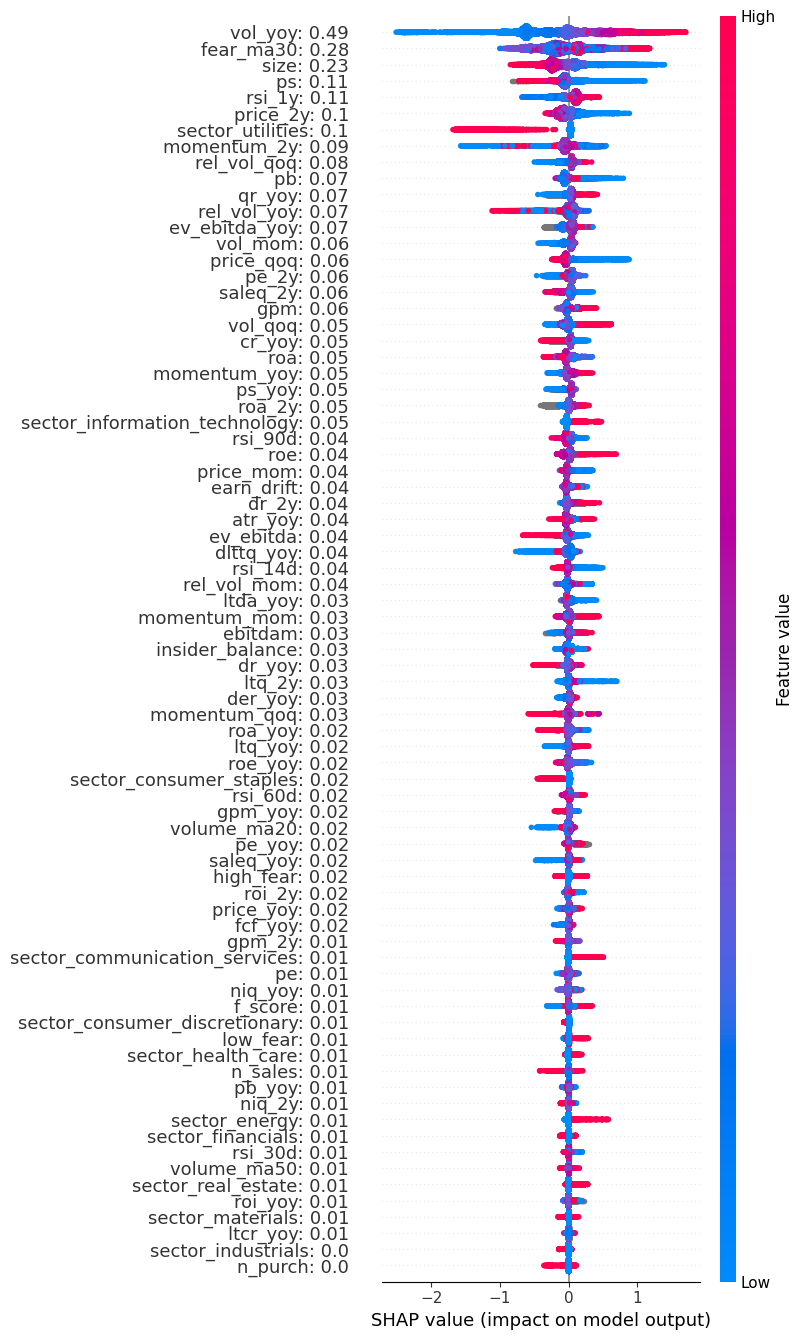

In [15]:
import numpy as np
import shap

explainer = shap.TreeExplainer(model.model)
shap_values = explainer(X_train)

feature_names = [
    a + ": " + str(b)
    for a, b in zip(X_train.columns, np.abs(shap_values.values).mean(0).round(2), strict=False)
]

shap.summary_plot(
    shap_values,
    X_train,
    max_display=X_train.shape[1],
    feature_names=feature_names,
    plot_size=(8, 13.5),
)